<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration10_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 번역기를 만들어보자  
이번에는 노드에서 했던 글자 단위가 아닌 단어 단위의 번역기를 만들어 봅시다.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re
import tensorflow as tf

## 1. 데이터 전처리  
일단 동일하게 영어, 프랑스어가 담긴 데이터를 데이터를 불러옵니다. 

In [2]:
file_path = '/content/drive/MyDrive/Colab/Datasets/translator/data/fra.txt'
lines_all = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
lines_all.sample(5)

,eng,fra,cc
193520,The athletes trained hard every day to be at t...,"Les athlètes se sont entrainés dur, tous les j...",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
80103,"In case of fire, dial 119.","En cas d'incendie, composez le 119.",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
56264,I live with my parents.,Je vis avec mes parents.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
124966,Tom is the tallest in our class.,Tom est le plus grand de notre classe.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
111014,The boy was sold into slavery.,Le garçon fut vendu en esclavage.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


데이터는 33000개만 사용하기 위해서 따로 담아줍니다.

In [3]:
lines = lines_all[['eng', 'fra']][:33000]

In [4]:
lines.sample(5)

,eng,fra
4442,Are you sure?,Êtes-vous sûres ?
28641,"Get real, will you?","Sois réaliste, tu veux ?"
11270,Keep on trying.,Continue d'essayer.
7622,I will return.,Je reviendrai.
11684,"Thank you, sir.","Merci, Monsieur."


다음은 문장 전처리입니다.  
모두 소문자로 변경, 구두점 분리, \<start>, \<end> 키워드 추가 등 전처리를 해줍니다.

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [6]:
lines['eng_pre'] = lines['eng'].map(preprocess_sentence)
lines['fra_pre'] = lines['fra'].map(preprocess_sentence)

In [7]:
lines.sample(5)

,eng,fra,eng_pre,fra_pre
23061,He earns a living.,Il gagne de quoi vivre.,<start> he earns a living . <end>,<start> il gagne de quoi vivre . <end>
6232,We got lucky.,On a eu de la chance.,<start> we got lucky . <end>,<start> on a eu de la chance . <end>
29039,Here are your keys.,Voici vos clés.,<start> here are your keys . <end>,<start> voici vos cl s . <end>
12811,You're invited.,Vous êtes invité.,<start> you re invited . <end>,<start> vous tes invit . <end>
8457,Take a number.,Prends un numéro !,<start> take a number . <end>,<start> prends un num ro ! <end>


다음은 문장의 길이를 측정하여 maxlen을 설정할 수 있도록 가장 긴 문장의 길이를 알아두도록 합시다.

In [8]:
lines['eng_len'] = lines.eng_pre.str.count(' ') + 1
lines['fra_len'] = lines.fra_pre.str.count(' ') + 1

In [9]:
lines.head(5)

,eng,fra,eng_pre,fra_pre,eng_len,fra_len
0,Go.,Va !,<start> go . <end>,<start> va ! <end>,4,4
1,Go.,Marche.,<start> go . <end>,<start> marche . <end>,4,4
2,Go.,Bouge !,<start> go . <end>,<start> bouge ! <end>,4,4
3,Hi.,Salut !,<start> hi . <end>,<start> salut ! <end>,4,4
4,Hi.,Salut.,<start> hi . <end>,<start> salut . <end>,4,4


In [10]:
eng_max_len = lines.eng_len.max()
fra_max_len = lines.fra_len.max()

In [11]:
print(eng_max_len, fra_max_len)

10 17


가장 긴 영어문장은 10, 프랑스어 문장은 17입니다.  
이에 맞춰서 maxlen을 설정하고 토큰화를 진행합니다.  
단어장 크기는 15000으로 하겠습니다.

In [12]:
def tokenize(corpus, padding='post', maxlen=15):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )
    
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=padding, maxlen=maxlen)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

In [13]:
eng_tensor, eng_tokenizer = tokenize(lines['eng_pre'], maxlen=eng_max_len)
fra_tensor, fra_tokenizer = tokenize(lines['fra_pre'], maxlen=fra_max_len)

[[ 2 32  4 ...  0  0  0]
 [ 2 32  4 ...  0  0  0]
 [ 2 32  4 ...  0  0  0]
 ...
 [ 2 39 40 ...  0  0  0]
 [ 2 39 40 ...  0  0  0]
 [ 2 39 40 ...  0  0  0]] <keras_preprocessing.text.Tokenizer object at 0x7ff044a2fad0>
[[   2   77    9 ...    0    0    0]
 [   2  380    4 ...    0    0    0]
 [   2  720    9 ...    0    0    0]
 ...
 [   2   36 4599 ...    0    0    0]
 [   2   36 4599 ...    0    0    0]
 [   2   74   60 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7ff044a2fa90>


In [14]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1

In [15]:
print(eng_vocab_size, fra_vocab_size)

4675 7462


성공적으로 토큰화가 진행되었습니다. 영어, 프랑스어의 단어장 크기는 각각 4675, 7462네요.  
\<start>가 2, \<end>가 3으로 대체되어 문장의 시작, 끝에 2, 3이 추가된 것을 볼 수 있습니다.  
이제 encoder에 넣을 eng_tensor를 encoder_input으로 하고, decoder의 input, target은 각각 시작, 끝 키워드를 제거한 버전으로 지정해 줍시다.  
input은 \<end>를 지우고 target은 \<start>를 제거해 줍니다.

In [16]:
encoder_input = eng_tensor
decoder_input = np.array([[ char for char in line if char != 3 ] for line in fra_tensor])
decoder_target = np.array([[ char for char in line if char != 2 ] for line in fra_tensor])

In [17]:
print(decoder_input[:3])
print(decoder_target[:3])

[[  2  77   9   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2 380   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2 720   9   0   0   0   0   0   0   0   0   0   0   0   0   0]]
[[ 77   9   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [380   4   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [720   9   3   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [18]:
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 10)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


성공적으로 분리가 되었습니다. 이제 validation set을 분리해 줍니다. 33000개중에 3000개를 사용하도록 합시다.

In [19]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

print('영어 Valid 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 Valid 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 Valid 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (30000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 16)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 16)
영어 Valid 데이터의 크기(shape) : (3000, 10)
프랑스어 Valid 입력데이터의 크기(shape) : (3000, 16)
프랑스어 Valid 출력데이터의 크기(shape) : (3000, 16)


## 2. 모델훈련  
데이터는 준비를 모두 마쳤습니다.  
이제 LSTM Layer를 사용하여 학습을 진행해 줍시다.  
이번엔 임베딩 층을 사용하여 입력 신호를 벡터화 합니다.

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [21]:
encoder_inputs = Input(shape=(None, ))
encoder_emb = Embedding(eng_vocab_size, 256, input_length=eng_max_len)(encoder_inputs)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb)
encoder_states = [state_h, state_c]

In [22]:

decoder_inputs = Input(shape=(None, ))
decoder_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(decoder_emb, initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [23]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1196800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1910272     ['input_2[0][0]']                
                                                                                              

준비된 모델을 학습시켜 주도록 하자.

In [24]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size=128, epochs=20)

Epoch 1/20
235/235 [==============================] - 14s 21ms/step - loss: 1.9263 - val_loss: 1.8110
Epoch 2/20
235/235 [==============================] - 4s 16ms/step - loss: 1.3947 - val_loss: 1.6000
Epoch 3/20
235/235 [==============================] - 4s 16ms/step - loss: 1.1999 - val_loss: 1.4501
Epoch 4/20
235/235 [==============================] - 4s 16ms/step - loss: 1.0822 - val_loss: 1.3647
Epoch 5/20
235/235 [==============================] - 4s 16ms/step - loss: 0.9898 - val_loss: 1.3092
Epoch 6/20
235/235 [==============================] - 4s 16ms/step - loss: 0.9135 - val_loss: 1.2511
Epoch 7/20
235/235 [==============================] - 4s 16ms/step - loss: 0.8493 - val_loss: 1.2093
Epoch 8/20
235/235 [==============================] - 4s 16ms/step - loss: 0.7928 - val_loss: 1.1800
Epoch 9/20
235/235 [==============================] - 4s 16ms/step - loss: 0.7427 - val_loss: 1.1527
Epoch 10/20
235/235 [==============================] - 4s 16ms/step - loss: 0.6979 - val_l

In [25]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1196800   
                                                                 
 lstm (LSTM)                 [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,722,112
Trainable params: 1,722,112
Non-trainable params: 0
_________________________________________________________________


학습된 모델의 Loss를 epoch별로 표현하면 아래와 같다.  

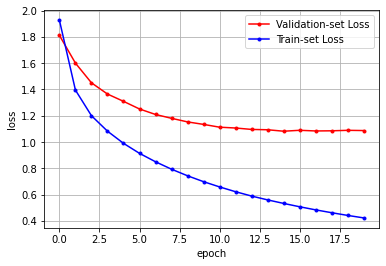

In [28]:
import matplotlib.pyplot as plt

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Train Loss는 20에폭 이후에도 줄어들지 않지만 Val Loss는 더이상 떨어지지 않는다.  
이제 디코더를 설계해 주자.

In [29]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_emb, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]

여기서 훈련과정에서 사용했던 디코더의 임베딩 레이어를 사용해야 한다고 한다.

In [30]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1910272     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

## 3. 모델 평가하기
다음은 단어에서 정수로, 정수에서 단어로 만드는 사전을 각각 tokenizer에서 가져옵니다.

In [31]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

다음은 예측 과정을 위한 함수를 구현합니다.  
번역하고자 하는 문장의 정수 시퀀스를 입력하면 번역 문장을 위한 예측을 시작합니다.  

In [32]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx['<start>']

    stop_condition = False
    decoded_sentence = ""
    decoded_len = 1

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        decoded_sentence += ' ' + sampled_char
        decoded_len += 1

        if (sampled_char == '<end>' or decoded_len > fra_max_len):
          stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

이제 문장 5개를 입력하여 번역이 잘 되는지 확인해 보겠습니다.

In [34]:
import numpy as np
for seq_index in [2000,4000,6000,8000,10000]:
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index])
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: I made tea.
정답 문장: J'ai préparé du thé.
번역기가 번역한 문장:  j ai fait des lunettes . <end
-----------------------------------
입력 문장: Tom shot me.
정답 문장: Tom m'a tiré dessus.
번역기가 번역한 문장:  tom m a tir dessus . <end
-----------------------------------
입력 문장: Tom did this.
정답 문장: C'est ce qu'a fait Tom.
번역기가 번역한 문장:  tom a fait a ! <end
-----------------------------------
입력 문장: It's a rental.
정답 문장: C'est une location.
번역기가 번역한 문장:  c est une triste . <end
-----------------------------------
입력 문장: Have you eaten?
정답 문장: Avez-vous mangé ?
번역기가 번역한 문장:  tu as mang ? <end


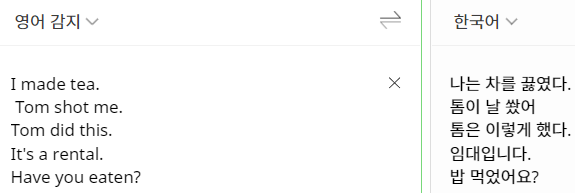

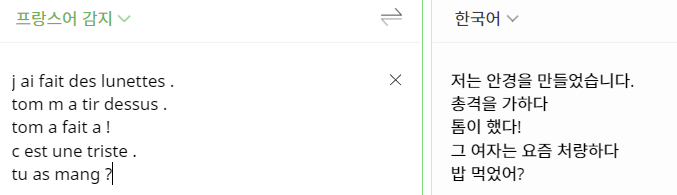

대충 비슷한 뜻으로 번역 하는것 같다. 1, 4번째 빼고...

## 4.회고
1. 단어 단위로 번역을 하려니 바꿔야 할 부분이 많아서 멘탈이 흔들렸지만 저번에 했던 익스6이었나 작사가 인공지능 만들기 했던 부분을 보면서 전처리 하는데 도움이 되었다.
2. 번역이 조금 이상하게 되었는데 이게 보니까 프랑스어의 약간 특수문자처럼 생긴 알파벳들은 다 제외된 것 같다. 그게 아니라면 조금 더 좋은 학습이 되지 않았을까? maxlen을 측정할 때도 영어가 10이고 프랑스어가 17이었는데 그 특수문자들이 사라지면서 문장이 길어진게 아닌가 싶다.